# Plot all products

Plot all products from the cleaned 50k data set for use with the interactive heatmap

In [2]:
import pathlib
import re
import sys
from io import StringIO
from IPython.display import display, SVG

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.color_palette import BodeColorPalette

In [3]:
# connect to DB
con = SynFermDatabaseConnection()

In [4]:
res = con.con.execute('SELECT e.id, r.I_long, r.M_long, r.T_long, r.product_A_smiles, r.reaction_smiles, l.binary_A, l.binary_B, l.binary_C, l.binary_D, l.binary_E, l.binary_F, l.binary_G, l.binary_H, l.scaled_A, l.scaled_B, l.scaled_C, l.scaled_D, l.scaled_E, l.scaled_F, l.scaled_G, l.scaled_H, l."major_A-C" FROM experiments e LEFT JOIN representations r on e.id = r.experiment_id INNER JOIN labels l on e.id = l.experiment_id;').fetchall()

columns = [
    "experiment_id", 
    "I_long", 
    "M_long", 
    "T_long", 
    "product_A_smiles", 
    "reaction_smiles", 
    "binary_A", 
    "binary_B", 
    "binary_C", 
    "binary_D", 
    "binary_E", 
    "binary_F", 
    "binary_G", 
    "binary_H", 
    "scaled_A", 
    "scaled_B", 
    "scaled_C", 
    "scaled_D", 
    "scaled_E", 
    "scaled_F", 
    "scaled_G", 
    "scaled_H", 
    "major_A-C",
]
df = pd.DataFrame(res, columns=columns)

In [5]:
df.head()

,experiment_id,I_long,M_long,T_long,product_A_smiles,reaction_smiles,binary_A,binary_B,binary_C,binary_D,...,binary_H,scaled_A,scaled_B,scaled_C,scaled_D,scaled_E,scaled_F,scaled_G,scaled_H,major_A-C
0,10578,Ph023,Mon017,TerTH010,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(C=Cc2ccccc2)s1)N...,O=C(c1ccc(Cl)cc1)[B-](F)(F)F.CC(C)(C)OC(=O)CC[...,1,1,1,0,...,1.0,2.430935,1.277949,0.285254,0.000000,0.413053,0.232611,5.452566,0.290557,A
1,10579,Ph023,Mon017,TerTH026,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cn[nH]c2)s1)N...,O=C(c1ccc(Cl)cc1)[B-](F)(F)F.CC(C)(C)OC(=O)CC[...,1,1,1,0,...,0.0,0.382317,0.926318,0.240020,0.000000,0.064906,0.339427,5.693844,0.000000,B
2,10580,Ph023,Mon017,TerTH015,CC(C)(C)OC(=O)CC[C@@H](Cc1nnc(-c2cc(Cl)cc(Cl)c...,O=C(c1ccc(Cl)cc1)[B-](F)(F)F.CC(C)(C)OC(=O)CC[...,1,1,1,0,...,0.0,0.931135,0.867479,0.042005,0.000000,0.000000,0.291865,5.596290,0.000000,A
3,10581,Ph023,Mon017,TerTH020,CN(C)c1cccc(-c2nnc(C[C@H](CCC(=O)OC(C)(C)C)NC(...,O=C(c1ccc(Cl)cc1)[B-](F)(F)F.CC(C)(C)OC(=O)CC[...,1,1,1,1,...,1.0,2.138999,2.543982,0.074154,0.000830,0.283941,0.321137,6.585098,0.213757,B
4,10584,Ph023,Mon017,TerABT001,CC(C)(C)OC(=O)CC[C@@H](Cc1nc2ccccc2s1)NC(=O)c1...,O=C(c1ccc(Cl)cc1)[B-](F)(F)F.CC(C)(C)OC(=O)CC[...,1,1,0,1,...,1.0,2.400752,0.011716,0.000000,0.001561,0.209155,1.204209,7.226035,0.811754,A


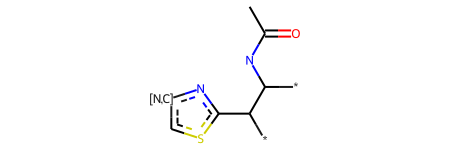

In [54]:
template = Chem.RWMol(Chem.MolFromSmarts("[#6]-C(=O)-[NH1]-C(-[*])-C(-[*])-c1:n:[n,c]:c:s:1"))

AllChem.Compute2DCoords(template, canonOrient=False, sampleSeed=50, nSample=200)
template

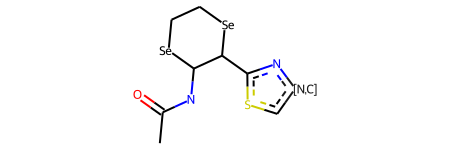

In [59]:
# n.b. we use the SE-ethers to get a nice orientation for the molecule
template = Chem.RWMol(Chem.MolFromSmarts("[#6]-C(=O)-[NH1]-C(-[Se]1)-C(-[Se]-C-C-1)-c1:n:[n,c]:c:s:1"))

AllChem.Compute2DCoords(template, canonOrient=True, sampleSeed=0, nSample=1)
template

In [60]:
for atom in template.GetAtoms():
    print(atom.GetIdx(), atom.GetSymbol())

0 C
1 C
2 O
3 N
4 C
5 Se
6 C
7 Se
8 C
9 C
10 C
11 N
12 *
13 C
14 S


In [61]:
# delete the placeholder atoms
template.RemoveAtom(9)
template.RemoveAtom(8)
template.RemoveAtom(7)
template.RemoveAtom(5)

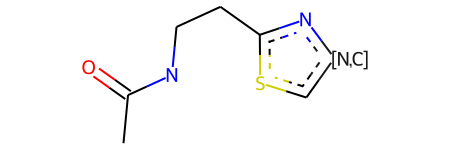

In [62]:
template

In [63]:
for i, row in df.iterrows():
    m = Chem.MolFromSmiles(row["product_A_smiles"])
    _ = AllChem.GenerateDepictionMatching2DStructure(m, template, allowRGroups=True)

    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    d.DrawMolecule(m)
    d.FinishDrawing()
    with open(f"product_images/{row['I_long']}_{row['M_long']}_{row['T_long']}.svg", "w") as f:
        f.write(re.sub('<rect.*</rect>\n', '', d.GetDrawingText()))  # remove background with regex